# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [1]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.0 MB 5.1 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/11.0 MB 8.4 MB/s eta 0:00:01
   ------------------ --------------------- 5.0/11.0 MB 9.0 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 9.3 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------  10.7/11.0 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/12.8 MB 8.1 MB/s eta 0:00:02
   ---------- ----------------------------- 3.4/12.8 MB 8.7 MB/s eta 0:00:02
   ---------------- ----------------------- 5.2/12.8 MB 9.0 MB/s eta 0:00:01
   ---------------------- ----------------- 7.1/12.8 MB 8.9 MB/s eta 0:00:01
   --------

In [4]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf

## Get the list of stocks in the S&P 500 

In [5]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [6]:
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [ ]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks 
# and the value is the output news from the yfinance library

news_dict = {}

for ticker in ticker_list:
    try:
        news_dict[ticker] = yf.Ticker(ticker).news
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")
        news_dict[ticker] = []


In [ ]:
# Printing one Ticker to see the data structures
print(news_dict["AAPL"])

[{'id': '8fbd7a35-3813-4bc1-b801-efff252e9e68', 'content': {'id': '8fbd7a35-3813-4bc1-b801-efff252e9e68', 'contentType': 'STORY', 'title': 'Stock market today: Dow, S&P 500, Nasdaq futures hit pause after record-setting rally', 'description': '', 'summary': 'US stock futures held steady after President Trump visited the Federal Reserve and Wall Street digested the latest batch of corporate earnings.', 'pubDate': '2025-07-24T23:30:28Z', 'displayTime': '2025-07-25T12:49:24Z', 'isHosted': True, 'bypassModal': False, 'previewUrl': None, 'thumbnail': {'originalUrl': 'https://s.yimg.com/os/creatr-uploaded-images/2025-07/2db0c5c0-68be-11f0-b7bf-f5f88947536e', 'originalWidth': 6000, 'originalHeight': 4000, 'caption': '', 'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/Vs.TfJkScbOxQhatoWLg3g--~B/aD00MDAwO3c9NjAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2025-07/2db0c5c0-68be-11f0-b7bf-f5f88947536e', 'width': 6000, 'height': 4000, 'tag': 'original'}, {'url':

### Structure the news into a pandas dataframe 

Your final dataframe should have the following columns: 
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [28]:
news_list = []

for ticker, news in news_dict.items():
    for item in news:
        news_list.append({
            'TICKER': ticker,
            'TITLE': item['content']['title'],
            'SUMMARY': item['content']['summary'],
            'PUBLICATION_DATE': item['content']['pubDate'],
            'URL': item['content']['canonicalUrl']['url']
        })

In [33]:
df_news = pd.DataFrame.from_records(news_list,  columns=['TICKER', 'TITLE', 'SUMMARY', 'PUBLICATION_DATE', 'URL'])
display(df_news.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [ ]:
# Using the `sentence-transformers/all-MiniLM-L6-v2` model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# New column "EMBEDDED_TEXT" containing the "TITLE" of the news
df_news['EMBEDDED_TEXT'] = df_news['TITLE'].fillna('')
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)

# New column "EMBEDDED_TEXT" containing the embedding vectors
df_news['EMBEDDINGS'] = embeddings.tolist()

Batches: 100%|██████████| 157/157 [00:08<00:00, 18.59it/s]


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [46]:
df_news = df_news.drop_duplicates(subset=['TICKER'])
print(len(df_news['EMBEDDINGS']))

502


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [ ]:
silhouette_scores = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df_news['CLUSTER'] = kmeans.fit_predict(df_news['EMBEDDINGS'].tolist())

    # Calculating the silhouette score
    score = silhouette_score(df_news['EMBEDDINGS'].tolist(), df_news['CLUSTER'])
    silhouette_scores.append(score)

#### Plot silhouette scores

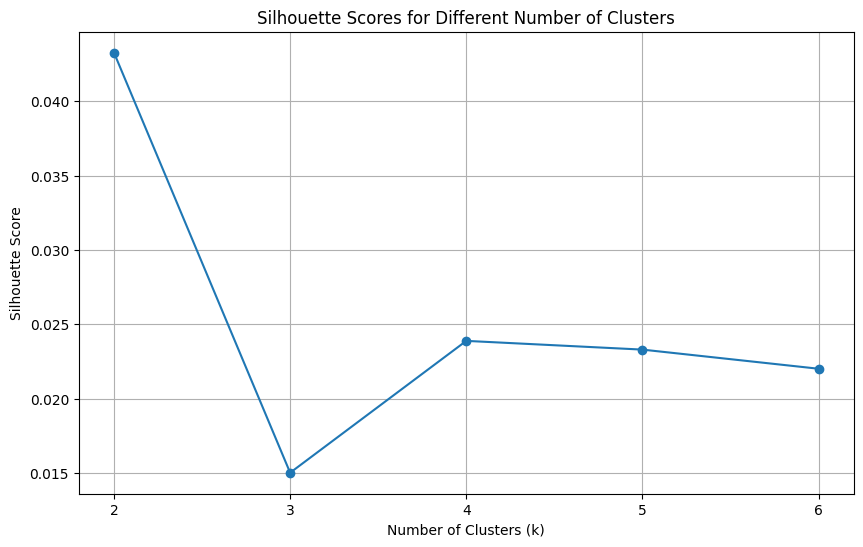

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 7), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 7))
plt.grid()
plt.show()


#### Identify the Best k

In [ ]:
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 2


#### Cluster the embeddings using 3 clusters (k=3)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_news['CLUSTER'] = kmeans.fit_predict(df_news['EMBEDDINGS'].tolist())

### Visualize the 2 first PCA Components of your embeddings

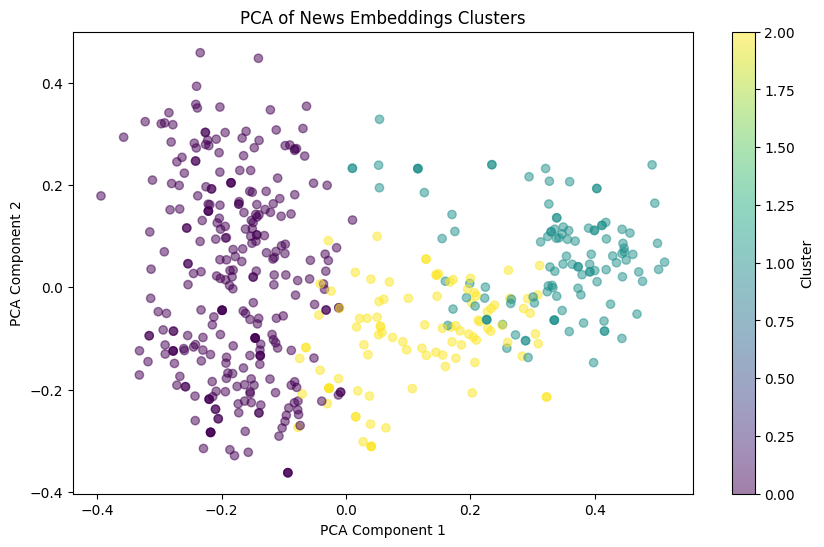

In [ ]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(df_news['EMBEDDINGS'].tolist())
plt.figure(figsize=(10, 6))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=df_news['CLUSTER'], cmap='viridis', alpha=0.5)
plt.title('PCA of News Embeddings Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [72]:
for cluster, group in df_news.groupby('CLUSTER'):
    print(f"\nCluster {cluster}:")
    for _, row in group.iterrows():
        print(f"TICKER: {row['TICKER']}, PUBLICATION_DATE: {row['PUBLICATION_DATE']}, TITLE: {row['TITLE']}")


Cluster 0:
TICKER: MMM, PUBLICATION_DATE: 2025-07-24T09:03:00Z, TITLE: 3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer
TICKER: ABT, PUBLICATION_DATE: 2025-07-24T13:38:14Z, TITLE: Abbott Laboratories (ABT): A Bull Case Theory
TICKER: ACN, PUBLICATION_DATE: 2025-07-24T13:00:02Z, TITLE: Accenture PLC (ACN) is Attracting Investor Attention: Here is What You Should Know
TICKER: ADBE, PUBLICATION_DATE: 2025-07-24T15:23:45Z, TITLE: Amazon Gave Prime Day Shoppers More Time to Browse. Many Went to Walmart
TICKER: AFL, PUBLICATION_DATE: 2025-07-24T04:05:54Z, TITLE: 3 Reasons AFL is Risky and 1 Stock to Buy Instead
TICKER: APD, PUBLICATION_DATE: 2025-07-25T00:00:00Z, TITLE: Green Hydrogen Boom Fizzles as Projects Collapse Worldwide
TICKER: ABNB, PUBLICATION_DATE: 2025-07-25T11:37:31Z, TITLE: Warren Buffett Says His $31,500 House Brings Him More Joy Than 10 Mansions — And He'd Rather Eat A McDonald's Burger Than A $100 Meal
TICKER: ALB, PUBLICATION_DATE: 2025-07-24



## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

The model MiniLM is a smaller, more efficient model that can produce embeddings quickly and with less computational resources. However, it may not capture the nuances of language as well as larger transformer models, potentially leading to less accurate clustering results.

On the other hand, larger models may require more computational resources and time to process, which could be a limitation in scenarios with large datasets or real-time applications. Therefore, the choice of embedding model should balance the need for accuracy with the available computational resources and the specific requirements of the analysis task.

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

Using only the **TITLE** produced embeddings that capture the main news topic, but it left out the details the **SUMMARY** has.

Using only the **SUMMARY** would produce embeddings that encapsulate more detailed information, leading to richer representations of the news content.

Combining both (TITLE and SUMMARY) would likely produce embeddings that balance the thematic focus of the **TITLE** with the detailed context of the **SUMMARY**, potentially leading to more precise representations.

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

Using a different dimensionality reduction method like **t-SNE** or **UMAP** would be preferable when:
- The dataset has a complex structure or non-linear relationships that PCA might not capture effectively.
- You want to preserve local structures and relationships within the data, as t-SNE and UMAP are designed to maintain local distances better than PCA.
- You are dealing with high-dimensional data where PCA might oversimplify the relationships, leading to misleading visualizations.
- You need to visualize clusters in a way that highlights their differences, as t-SNE and UMAP often produce more visually distinct clusters compared to PCA.



---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

The principal challenge here is the potential overlap between clusters, where news may belong to multiple themes or topics, making it difficult to assign a clear label to each cluster. This can lead to ambiguity in interpreting the clusters and their significance.
To address this, one strategy is to use a more sophisticated clustering algorithm that can handle overlapping clusters, such as hierarchical clustering or density-based clustering methods like DBSCAN. These methods can help identify clusters with varying densities and shapes, allowing for a more nuanced understanding of the data.

Another challenge is the potential for noise in the data, where irrelevant or low-quality news may skew the clustering results. This can lead to clusters that do not accurately represent the underlying themes in the data.
To mitigate this, it is essential to implement a robust data cleaning and preprocessing pipeline that filters out noise and irrelevant articles. Techniques such as removing stop words, stemming, and lemmatization can help improve the quality of the embeddings and, consequently, the clustering results.

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

Yes, some outliers are visible in the PCA plot.

A few points in the top-left quadrant that are distant from their cluster centroid.
A few isolated points in the bottom-left and top-right quadrants also appear distant from others within their clusters.

To identify and handle these outliers in a production pipeline, I can think of strategies implemented in other courses of this program:

**Statistical Analysis**: Use statistical methods such as Z-scores or IQR (Inter-quartile Range) to identify points that deviate significantly from the mean or median of their respective clusters.

**Distance Metrics**: Calculate the distance of each point from its cluster centroid using metrics like Euclidean distance. Points with distances greater than a certain threshold (e.g., 1.5 times the average distance) can be flagged as outliers.

**Visual Inspection**: Use visualization techniques like box plots or scatter plots to visually inspect the data and identify points that do not conform to the expected distribution of their clusters.

**Handling Outliers**: Depending on the analysis, outliers can be handled in several ways:
   - **Removal**: If the outliers are deemed irrelevant or erroneous, they can be removed from the dataset.
   - **Transformation**: Apply transformations to reduce the impact of outliers, such as log transformation or winsorization.
   - **Separate Analysis**: Analyze outliers separately to understand their characteristics and potential implications for the overall analysis.

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

The label or theme for each cluster could be assigned based on the predominant topics or sentiments expressed in the news within that cluster. For example, clusters could be labeled as "Technology Innovations," "Market Trends," "Regulatory Changes," or "Corporate Earnings."

The confidence in these assignments would depend on the clarity and distinctiveness of the clusters observed in the PCA visualization and the coherence of the news within each cluster. To validate these assignments systematically, I could:
- **Manual Review**: Conduct a manual review of a sample of articles from each cluster to ensure that the assigned labels accurately reflect the content and themes of the articles.
- **Expert Consultation**: Consult with domain experts or financial analysts to validate the thematic assignments and ensure they align with industry standards and expectations.
- **Automated Topic Modeling**: Use topic modeling techniques (e.g., LDA) to automatically identify themes within the clusters and compare them with the manually assigned labels.

---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

Incorporating news sentiment into the analysis could significantly influence the clustering structure and interpretation of the clusters in a financial analysis context. Sentiment analysis can provide additional context to the news articles, allowing for a more nuanced understanding of how news affects market perceptions and behaviors.

Clusters may become more distinct as sentiment adds another layer of information. For example, a cluster of positive sentiment news may emerge separately from a cluster of negative sentiment news, even if the topics are similar.

Clusters may form around specific sentiment trends, such as "Positive Market Sentiment" or "Negative Regulatory News," allowing for a more targeted analysis of how sentiment influences market movements. also, including sentiment could improve the predictive power of the clusters, as sentiment often correlates with stock price movements.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

K-means clustering has several limitations when applied to news embeddings, such as assuming that clusters are spherical and evenly sized, which may not be true for news that can have complex and non-linear relationships. On the same line, the algorithm is sensitive to the initial placement of centroids, which can lead to different clustering results on different runs.

Another limitations of the K-means clustering is that requires the number of clusters beforehand, which can be challenging when the optimal number of clusters is not known. And due to the fact that K-means is sensitive to outliers, it can disproportionately affect the cluster centroids and lead to misleading results.

Alternative clustering methods that could address these limitations include:

- **Hierarchical Clustering**: This method does not require a predefined number of clusters and can produce a dendrogram that shows the relationships between clusters at different levels of granularity. It is useful for understanding the hierarchical structure of the data.
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: This method can identify clusters of varying shapes and sizes, making it suitable for complex datasets. It also has the advantage of being robust to outliers, as it can classify them as noise.
- **Gaussian Mixture Models (GMM)**: GMMs allow for clusters to have different shapes and sizes by modeling the data as a mixture of multiple Gaussian distributions. This can provide a more flexible clustering approach compared to k-means.
- **Affinity Propagation**: This method does not require the number of clusters to be specified beforehand and can identify exemplars within the data, which can be useful for clustering news articles based on their content.

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

So far, in this notebook, we have focused on clustering news articles based on their embeddings:

1. **Data Collection**:
   - Retrieve historical stock price data for the S&P 500 companies using `yfinance`.
   - Collect news articles and their embeddings as done in this notebook.
2. **Clustering**:
   - Apply clustering techniques (e.g., K-means, DBSCAN) to group news articles based on their embeddings.


To extend this approach to analyze the potential impact of news clusters on stock price movements over time, I would implement the following high-level pipeline:

3. **Sentiment Analysis**:
   - Perform sentiment analysis on the news articles to quantify the sentiment associated with each cluster.
4. **Feature Engineering**:
   - Create features based on the clusters and sentiment scores, such as number of articles in each cluster per day, average sentiment score for each cluster per day and take into account for the time delay between news publication and stock price reaction.
5. **Stock Price Analysis**:
   - Merge the news features with historical stock price data.
    - Calculate stock price movements (e.g., daily returns, volatility) for each company.
6. **Modeling**:
   - Use regression models (e.g., linear regression, time series models) to analyze the relationship between news clusters/sentiment and stock price movements.
   - Evaluate the predictive power of news clusters on stock price movements.
7. **Validation**:
   - Validate the model using out-of-sample testing or cross-validation to ensure robustness.
8. **Interpretation**:
   - Analyze the results to determine how different news clusters and sentiment levels impact stock price movements.
   - Visualize the findings to illustrate the relationship between news clusters and stock price movements over time.


---

#### 1️⃣0️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

The disconnect between clear clusters and predictive utility could be explained by several factors:

**Feature Redundancy**: The clusters may capture similar information that does not add significant predictive power to the model. If the features derived from the clusters are redundant with other features already in the dataset, they may not contribute additional value to the prediction task.

**Noise in Data**: The clusters may contain noise or irrelevant information that does not correlate with stock movements. If the clusters are influenced by noise or outliers, they may not provide meaningful insights for prediction.

**Temporal Dynamics**: The clusters may not account for the temporal dynamics of stock movements. For example, if the clusters are static and do not adapt to changing market conditions, they may not capture the evolving nature of stock movements.

